# Práctica 4: Entrenamiento de redes neuronales

Alumnos: Andrés Ruiz Bartolomé y Adrián de Lucas Gómez  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as minimize
import displayData as disp
import checkNNGradients as checkNNG

# Parte 1: Función de coste

En esta primera parte deberemos de implementar las funciones de coste y aplicarlas sobre los datos de 'ex4data1.mat'. Como en la practica anterior estaremos reconociendo numeros manuscritos.

En el archivo de 'ex4weights.mat' encontramos los pesos de una red neuronal ya entrenada.

Tras ver los valores del coste normal y el regularizado haciendo uso de **checkNNGradients** podemos ver los valores que han dado los gradientes y ver las variaciones que ha habido entre ellos.

Por último tendremos que entrenar la red con los métodos de **redNeuronalPaLante** y **redNeuronalPatras** usando la función minimize.

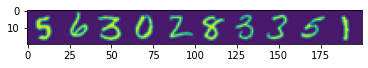

Se ha clasificado correctamente el 96.02% de los ejemplos de entrenamiento


In [11]:
def parte1():
    datos = loadmat('ex4data1.mat')
    X = datos['X']
    y = datos['y']
    y = np.ravel(y)

    m = len(y)
    input_size= np.shape(X)[1]
    num_hidden = 25
    num_labels = 10

    yAux = (y-1)
    y_onehot = np.zeros((m, num_labels))
    for i in range(m):
        y_onehot[i][yAux[i]] = 1

    sample = np.random.choice(X.shape[0], 100)
    disp.displayData(X[sample])
    plt.show()

    weights = loadmat('ex4weights.mat')
    theta1 = weights['Theta1']
    theta2 = weights['Theta2']

    print("Coste sin haber regularizado: ")
    print(str(coste(X, y_onehot, theta1, theta2))[:5])
    print("Coste regularizando con lambda valor 1: ")
    print(str(costeReg(X, y_onehot, theta1, theta2, 1))[:5])
    print()     #Salto de linea

    lambo = 1
    print("Comprobacion de las variaciones en el gradiente")
    diff = checkNNG.checkNNGradients(redNeuronalPatras, lambo)
    print()     #Salto de linea

    print("Menor diferencia: ")
    print(str(min(diff)))
    print("Mayor diferencia: ")
    print(str(max(diff)))
    print()     #Salto de linea


    #Elejimos valores aleatorios para las thetas
    theta1 = randomWeights(input_size, num_hidden)
    theta2 = randomWeights(num_hidden, num_labels)
    #Los guardamos para probar con ellos
    params_rn = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
    
    num_Iterations = 70     #Vueltas dadas para tratar de optimizar
    optimizeResult = minimize.minimize(fun=redNeuronalPatras, x0=params_rn, args=(input_size, num_hidden, num_labels, X, y_onehot, lambo), method='TNC', jac=True, options={'maxiter': num_Iterations})
    evaluations = precisionChecker(optimizeResult, input_size, num_hidden, num_labels, X, y)

    print("Precision de la red tras ser entrenada:")
    print(str(evaluations*100)[:5] + "%")

parte1()

Para el calculo del coste primero habrá que sacar la **H** con el método de la red neuronal y con ello hacemos el calculo.
Por su parte el coste regularizado lo que hace es sobre el coste normal añadimos el valor regularizador **lambo** junto a otros parámetros en el CosteR

In [7]:

def coste(X, Y, theta1, theta2):

	a1, a2, H = redNeuronalPaLante(X, theta1,theta2) #Haces la pasada por la red neuronal

    #Queda mas claro dividido por partes
	op1= -1/(len(X))
	op2 = Y * np.log(H)
	op3 = (1-Y) * np.log(1-H)

	cost = op1 * np.sum(op2 + op3)
	return cost

def costeReg(X, Y, theta1, theta2, lambo):
    costeN = coste(X, Y, theta1, theta2)
    costeR = costeN + (lambo/(2*len(X)) * (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:]))))
    return costeR

Para el cálculo del coste tendremos que hacer uso de las funciones **sigmoide** y **redNeuronalPaLante**.
En la pasada a la red neuronal tenemos que calcular la capa oculta y ver el resultado que da de salida y metiendo el resultado en la funcion sigmoide dando **a3**.

In [9]:
def redNeuronalPaLante(X, theta1, theta2):
    
    xSize = X.shape[0]
    # Capa de entrada
    a1 = np.hstack([np.ones((xSize,1)), X])    
    # Capa oculta    
    z2 = theta1.dot(a1.T)
    a2 = np.hstack([np.ones((xSize,1)),sigmoide(z2.T)])
    # Capa de salida
    z3 = np.dot(a2, theta2.T) 
    a3 = sigmoide(z3) #Es la hipotesis

    return (a1, a2, a3)

def sigmoide(x):
    s = 1 / (1 + np.exp(-x))
    return s

# Parte 2: Calculo del gradiente

Para hacer el descenso de gradiente con redes neuronales que entrenamos nosotros tendremos que recorrer la red neuronal en sentido contrario con el objetivo de ver cuales son los nodos que tienen un peor coste para tratar de reducir ese error.

In [12]:
def redNeuronalPatras(params_rn, n_input, n_hidden, n_labels, X, y, lambdita):
    theta1 = np.reshape(params_rn[:n_hidden * (n_input+1)], (n_hidden, (n_input+1)))
    theta2 = np.reshape(params_rn[n_hidden * (n_input+1):], (n_labels, (n_hidden+1)))
    
    m = len(X)
    A1, A2, H = redNeuronalPaLante(X, theta1, theta2)

    Delta1 = np.zeros_like(theta1)
    Delta2 = np.zeros_like(theta2)

    for t in range(m):
        a1t = A1[t, :]
        a2t = A2[t, :]
        ht = H[t, :]
        yt = y[t]

        d3t = ht - yt
        d2t = np.dot(theta2.T, d3t) * (a2t * (1 - a2t))

        Delta1 = Delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        Delta2 = Delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])

    
    #Gradientes
    G1= Delta1 / m
    G2 = Delta2 / m

    #Lambdas
    lambo1 = lambdita * theta1 / m
    lambo2 = lambdita * theta2 / m

    lambo1[:, 0] = 0
    lambo2[:, 0] = 0

    G1 += lambo1
    G2 += lambo2

    gradiente = np.concatenate((np.ravel(G1), np.ravel(G2)))

    #Coste
    coste = costeReg(X, y, theta1, theta2, lambdita)

    return coste, gradiente

Función que usamos para inicializar de forma aleatoria los valores de theta

In [13]:
def randomWeights(L_ini, L_out):
    E_ini = 0.12
    return np.random.random((L_out, L_ini + 1)) * (2*E_ini) - E_ini

Este método se encarga de utilizar la red neuronal ya entrenada para ver como de efectiva es clasificando ejemplos. Suele rondar un 93% +- 2& segun como hayan venido los theta inicializados.

In [14]:
def precisionChecker(resOpt, n_input, n_hidden, n_labels, X, y):
    theta1 = np.reshape(resOpt.x[:n_hidden * (n_input + 1)] , (n_hidden, (n_input+1)))
    theta2 = np.reshape(resOpt.x[n_hidden * (n_input + 1):] , (n_labels, (n_hidden+1)))

    A1, A2, H = redNeuronalPaLante(X, theta1, theta2)

    aux = np.argmax(H, axis=1)
    aux += 1
    #calculamos cuantos se han identificado correctamente y lo dividimos por los casos de prueba
    return np.sum(aux == y) / np.shape(H)[0]

La red neuronal clasifica correctamente el 97.52% de los casos.
